
Training LSTM + Attention
Epoch 1/10 - Loss: 0.293902
Epoch 2/10 - Loss: 0.028620
Epoch 3/10 - Loss: 0.013783
Epoch 4/10 - Loss: 0.012487
Epoch 5/10 - Loss: 0.011806
Epoch 6/10 - Loss: 0.012065
Epoch 7/10 - Loss: 0.012311
Epoch 8/10 - Loss: 0.011257
Epoch 9/10 - Loss: 0.010945
Epoch 10/10 - Loss: 0.011242

Training Baseline LSTM
Epoch 1/10 - Loss: 0.270563
Epoch 2/10 - Loss: 0.018203
Epoch 3/10 - Loss: 0.012485
Epoch 4/10 - Loss: 0.011767
Epoch 5/10 - Loss: 0.011787
Epoch 6/10 - Loss: 0.011575
Epoch 7/10 - Loss: 0.012891
Epoch 8/10 - Loss: 0.012105
Epoch 9/10 - Loss: 0.012422
Epoch 10/10 - Loss: 0.011639

Evaluation Results
------------------
Baseline LSTM     -> MAE: 0.0854, RMSE: 0.1065
LSTM + Attention  -> MAE: 0.0872, RMSE: 0.1085


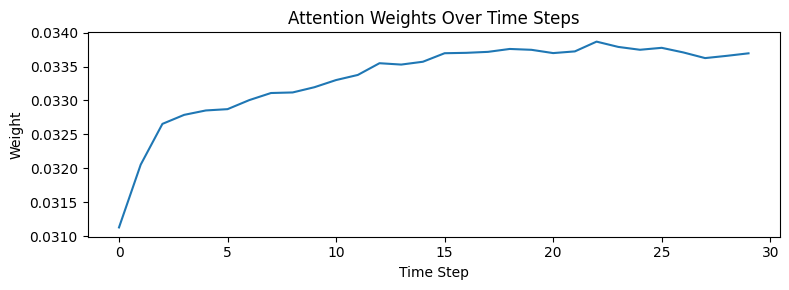

In [2]:
# =========================
# Advanced Time Series Forecasting (Single Cell)
# LSTM + Self Attention + Baseline
# =========================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------
# Reproducibility
# -------------------------
torch.manual_seed(42)
np.random.seed(42)

# -------------------------
# 1. Synthetic Dataset
# -------------------------
T = 1500
features = 5
seq_len = 30

t = np.arange(T)

data = np.stack([
    np.sin(0.02 * t) + 0.1 * np.random.randn(T),
    np.cos(0.015 * t) + 0.1 * np.random.randn(T),
    np.sin(0.01 * t) ** 2,
    np.log1p(t) / 5,
    np.sin(0.05 * t + 1)
], axis=1)

target = np.roll(data[:, 0], -1)

data = data[:-1]
target = target[:-1]

def make_sequences(x, y, seq_len):
    X, Y = [], []
    for i in range(len(x) - seq_len):
        X.append(x[i:i + seq_len])
        Y.append(y[i + seq_len])
    return np.array(X), np.array(Y)

X, y = make_sequences(data, target, seq_len)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)

test_ds = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

# -------------------------
# 2. Attention Layer
# -------------------------
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.score = nn.Linear(hidden_dim, 1)

    def forward(self, h):
        # h: (batch, seq_len, hidden)
        scores = self.score(h).squeeze(-1)          # (batch, seq_len)
        weights = torch.softmax(scores, dim=1)      # (batch, seq_len)
        context = torch.sum(h * weights.unsqueeze(-1), dim=1)
        return context, weights

# -------------------------
# 3. LSTM + Attention Model
# -------------------------
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attn = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, weights = self.attn(lstm_out)
        output = self.fc(context)
        return output.squeeze(-1), weights

# -------------------------
# 4. Baseline LSTM Model
# -------------------------
class LSTMBase(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        output = self.fc(h_n[-1])
        return output.squeeze(-1)

# -------------------------
# 5. Training Function
# -------------------------
def train_model(model, dataloader, epochs=10, lr=0.001):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for xb, yb in dataloader:
            optimizer.zero_grad()

            out = model(xb)
            preds = out[0] if isinstance(out, tuple) else out

            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(dataloader):.6f}")

# -------------------------
# 6. Train Models
# -------------------------
attn_model = LSTMAttention(features)
base_model = LSTMBase(features)

print("\nTraining LSTM + Attention")
train_model(attn_model, train_dl, epochs=10)

print("\nTraining Baseline LSTM")
train_model(base_model, train_dl, epochs=10)

# -------------------------
# 7. Evaluation
# -------------------------
def evaluate(model, dataloader):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            out = model(xb)
            y_pred = out[0] if isinstance(out, tuple) else out
            preds.extend(y_pred.numpy())
            trues.extend(yb.numpy())

    mae = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    return mae, rmse

mae_attn, rmse_attn = evaluate(attn_model, test_dl)
mae_base, rmse_base = evaluate(base_model, test_dl)

print("\nEvaluation Results")
print("------------------")
print(f"Baseline LSTM     -> MAE: {mae_base:.4f}, RMSE: {rmse_base:.4f}")
print(f"LSTM + Attention  -> MAE: {mae_attn:.4f}, RMSE: {rmse_attn:.4f}")

# -------------------------
# 8. Attention Visualization
# -------------------------
xb, _ = next(iter(test_dl))

attn_model.eval()
with torch.no_grad():
    _, attn_weights = attn_model(xb[:1])

plt.figure(figsize=(8, 3))
plt.plot(attn_weights[0].numpy())
plt.title("Attention Weights Over Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()